# Toy example for visualization

date = Oktober 07, 2020 <br>
author = c.magg

In [1]:
import vtk
from vtk.util import numpy_support

In [2]:
import os
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append(os.path.abspath('../../'))

## Prepare data folder

In [4]:
path_data = "examples/"
pngfiles = [os.path.join(path_data,x) for x in os.listdir(path_data)]
print(pngfiles)
filePath = vtk.vtkStringArray()
filePath.SetNumberOfValues(len(pngfiles))
for i in range(0,len(pngfiles),1):
    filePath.SetValue(i,pngfiles[i])
filePath

['examples/image01.png', 'examples/image02.png', 'examples/image03.png', 'examples/image04.png']


(vtkCommonCorePython.vtkStringArray)0000001DAE079C48

# Generate numpy data

In [5]:
number_time_steps = len(pngfiles)

## Generate mask and contour mask

In [6]:
contour_width = 2
contour_color = 255
bg_color = (1,1,1)

In [7]:
np_mask_list = []
np_contour_list = []
png_reader = vtk.vtkPNGReader()
for i,p in enumerate(pngfiles):
    # read pngs
    png_reader.SetFileName(p)
    png_reader.Update()
    img_data = png_reader.GetOutput()
    vtk_data = img_data.GetPointData().GetScalars()
    x,y,z = img_data.GetDimensions()
    print(p, x,y,z)
    # convert to numpy
    numpy_data = np.flip(numpy_support.vtk_to_numpy(vtk_data).reshape(x,y))
    np_mask_list.append(numpy_data)
    # generate contour
    pts = []
    tmp = cv2.findContours(numpy_data.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    for t in tmp:
        pts.append(t.reshape(t.shape[0], t.shape[2]))
    contour = np.zeros(numpy_data.shape, dtype=np.int16)
    for p in pts:
        vertices = p.astype(np.int32)
        if len(vertices) != 0:
            cv2.drawContours(contour, [vertices], -1, (contour_color), contour_width)
    np_contour_list.append(contour)
len(np.shape(np_mask_list)) == 3

examples/image01.png 512 512 1
examples/image02.png 512 512 1
examples/image03.png 512 512 1
examples/image04.png 512 512 1


True

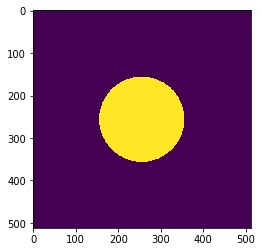

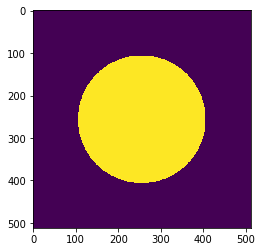

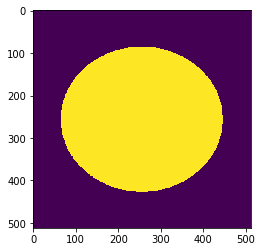

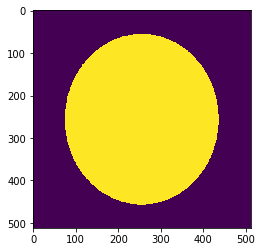

In [8]:
for mask in np_mask_list:
    plt.imshow(mask)
    plt.show()

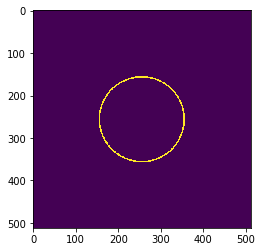

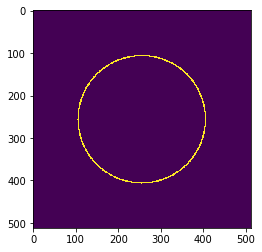

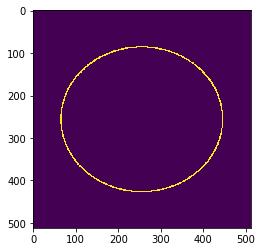

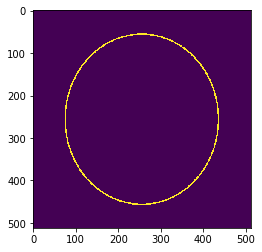

In [9]:
for mask in np_contour_list:
    plt.imshow(mask)
    plt.show()

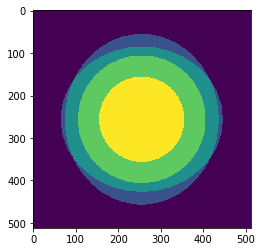

In [10]:
np_union_mask = np.sum(np_mask_list, axis=0)/number_time_steps
plt.imshow(np_union_mask)

In [11]:
np.unique(np_union_mask), np.shape(np_union_mask)

(array([  0.  ,  63.75, 127.5 , 191.25, 255.  ]), (512, 512))

## Generate distance transform

In [27]:
np_distance_transform = []
for idx in range(number_time_steps-1):
    contour1 = (~np_mask_list[idx]/255).astype(np.uint8)
    contour2 = (~np_mask_list[idx+1]/255).astype(np.uint8)
    dist = cv2.distanceTransform(contour1,cv2.DIST_L2, cv2.DIST_MASK_PRECISE )
    dist[contour2 != 0] = 0
    dist = dist/np.max(dist)*255
    #if idx == 0:
    #    dist[contour1==0] = 1
    np_distance_transform.append(dist)
len(np_distance_transform)

3

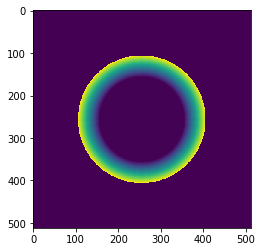

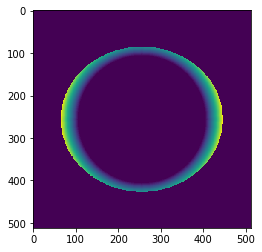

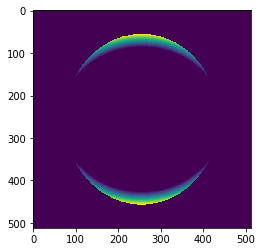

In [28]:
for idx in range(len(np_distance_transform)):
    plt.imshow(np_distance_transform[idx])
    #print(np.unique(np_distance_transform[idx]))
    plt.show()

# Generate vkt image data

In [29]:
vtk_distance = []
for idx in range(number_time_steps-1):
    # distance transforms
    vtk_dt = numpy_support.numpy_to_vtk(np_distance_transform[idx].ravel())
    vtk_imageData = vtk.vtkImageData()
    vtk_imageData.GetPointData().SetScalars(vtk_dt)
    vtk_imageData.SetDimensions((512,512,1))
    vtk_imageData.SetSpacing(1.0, 1.0, 1.0 )
    vtk_imageData.SetOrigin(0.0, 0.0, 0.0 )
    print(vtk_imageData.GetScalarRange())
    vtk_distance.append(vtk_imageData)

(0.0, 255.0)
(0.0, 255.0)
(0.0, 255.0)


In [30]:
vtk_contour = []
for idx in range(number_time_steps):
    # contour masks
    vtk_c = numpy_support.numpy_to_vtk(np_contour_list[idx].ravel())
    vtk_imageData = vtk.vtkImageData()
    vtk_imageData.GetPointData().SetScalars(vtk_c)
    vtk_imageData.SetDimensions((512,512,1))
    vtk_imageData.SetSpacing(1.0, 1.0, 1.0 )
    vtk_imageData.SetOrigin(0.0, 0.0, 0.0 )
    vtk_contour.append(vtk_imageData)
len(vtk_distance)

3

In [31]:
# ColorTransferFunction
ctf = []
colors = [(1,0,0),(0,1,0),(0,1,1),(0,0,1)]
for idx in range(number_time_steps-1):
    ctf01 = vtk.vtkColorTransferFunction()
    ctf01.AddRGBPoint(0, 1,1,1)
    ctf01.AddRGBPoint(1, *colors[idx])
    ctf01.AddRGBPoint(255, *colors[idx+1])
    ctf.append(ctf01)

In [32]:
ctf[0].GetRange()

(0.0, 255.0)

In [33]:
lut = []
for idx in range(number_time_steps-1):
    tableSize = 255
    lut01 = vtk.vtkLookupTable()
    lut01.SetNumberOfTableValues(tableSize)
    lut01.SetRampToLinear()
    for ii, ss in enumerate([float(xx) for xx in range(tableSize)]):
        cc = ctf[idx].GetColor(ss)
        #oo = otf.GetValue(ss)
        oo = 0.3
        lut01.SetTableValue(ii, cc[0], cc[1], cc[2], oo)
        lut01.Modified()
    lut01.SetRange(0,255)
    lut01.Build()
    lut.append(lut01)

In [34]:
lut[0].GetTableRange(), lut[0].GetValueRange(), lut[0].GetSaturationRange(), lut[0].GetHueRange()

((0.0, 255.0), (1.0, 1.0), (1.0, 1.0), (0.0, 0.66667))

In [35]:
lut_contour = vtk.vtkLookupTable()
lut_contour.SetNumberOfColors(2)
lut_contour.SetTableValue(0, 1,1,1, 0)
lut_contour.SetTableValue(1, 0,0,0, 1)
lut_contour.Build()
lut_contour.GetValueRange()

(1.0, 1.0)

In [36]:
actors = []
for idx in range(number_time_steps-1):
    scalarValuesToColors = vtk.vtkImageMapToColors()
    scalarValuesToColors.SetLookupTable(lut[idx])
    scalarValuesToColors.SetInputData(vtk_distance[idx])
    scalarValuesToColors.GetOutput()

    # Create an image actor
    actor = vtk.vtkImageActor()
    actor.GetMapper().SetInputConnection(scalarValuesToColors.GetOutputPort())
    #actor.GetProperty().SetOpacity(10.0)
    actors.append(actor)

In [37]:
actors_contour = []
for idx in range(number_time_steps):   
    scalarValuesToColors = vtk.vtkImageMapToColors()
    scalarValuesToColors.SetLookupTable(lut_contour)
    scalarValuesToColors.SetInputData(vtk_contour[idx])
    scalarValuesToColors.GetOutput()

    # Create an image actor
    actor = vtk.vtkImageActor()
    actor.GetMapper().SetInputConnection(scalarValuesToColors.GetOutputPort())
    #actor.GetProperty().SetOpacity(0.8)
    actors_contour.append(actor)

In [38]:
# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(*bg_color)
#for idx in range(len(actors)):
#    renderer.AddViewProp(actors[idx])
renderer.AddViewProp(actors[0])
#for idx in range(len(actors_contour)):
#    renderer.AddActor(actors_contour[idx])

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

window.Render()
interactor.Start()

In [59]:
actors[0].GetProperty().SetUseLookupTableScalarRange(True)

# 2D LUT

In [24]:
path_data = "examples02/"
pngfiles = [os.path.join(path_data,x) for x in os.listdir(path_data)]
print(pngfiles)
filePath = vtk.vtkStringArray()
filePath.SetNumberOfValues(len(pngfiles))
for i in range(0,len(pngfiles),1):
    filePath.SetValue(i,pngfiles[i])
filePath

['examples02/image01.png', 'examples02/image02.png']


(vtkCommonCorePython.vtkStringArray)000000599EAD9F48

In [25]:
number_time_steps = len(pngfiles)

In [26]:
pts1 = [(200,200), (200,300), (300,200), (300,300)]
pts2 = [(150,350), (350,350), (150,150), (350,150)]

In [27]:
np_mask_list = []
np_contour_list = []
png_reader = vtk.vtkPNGReader()
for i,p in enumerate(pngfiles):
    # read pngs
    png_reader.SetFileName(p)
    png_reader.Update()
    img_data = png_reader.GetOutput()
    vtk_data = img_data.GetPointData().GetScalars()
    x,y,z = img_data.GetDimensions()
    print(p, x,y,z)
    # convert to numpy
    numpy_data = np.flip(numpy_support.vtk_to_numpy(vtk_data).reshape(x,y))
    np_mask_list.append(numpy_data)
    # generate contour
    pts = []
    tmp = cv2.findContours(numpy_data.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    for t in tmp:
        pts.append(t.reshape(t.shape[0], t.shape[2]))
    contour = np.zeros(numpy_data.shape, dtype=np.int16)
    for p in pts:
        vertices = p.astype(np.int32)
        if len(vertices) != 0:
            cv2.drawContours(contour, [vertices], -1, (contour_color), contour_width)
    np_contour_list.append(contour)
len(np.shape(np_mask_list)) == 3

examples02/image01.png 512 512 1
examples02/image02.png 512 512 1


True

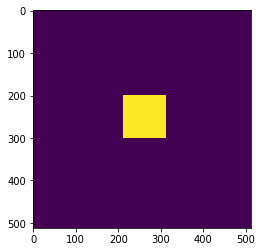

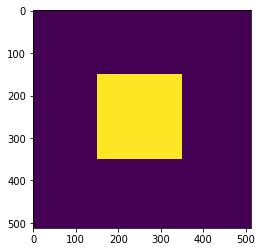

In [28]:
for mask in np_mask_list:
    plt.imshow(mask)
    plt.show()

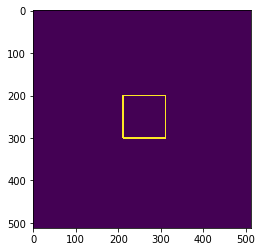

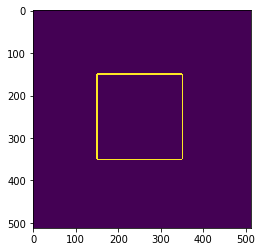

In [29]:
for mask in np_contour_list:
    plt.imshow(mask)
    plt.show()

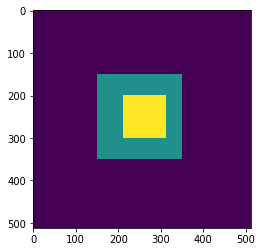

In [30]:
np_union_mask = np.sum(np_mask_list, axis=0)/number_time_steps
plt.imshow(np_union_mask)

In [31]:
np_distance_transform = []
for idx in range(number_time_steps-1):
    contour1 = (~np_mask_list[idx]/255).astype(np.uint8)
    contour2 = (~np_mask_list[idx+1]/255).astype(np.uint8)
    dist = cv2.distanceTransform(contour1+contour2,cv2.DIST_L12, cv2.DIST_MASK_PRECISE )
    dist[contour2 != 0] = 0
    dist = dist/np.max(dist)*255
    np_distance_transform.append(dist)
len(np_distance_transform)

1

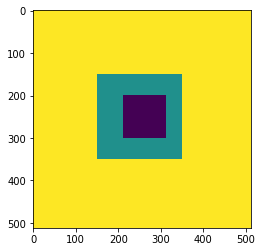

In [32]:
plt.imshow(contour1+contour2)

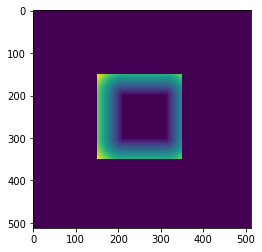

In [33]:
for idx in range(len(np_distance_transform)):
    plt.imshow(np_distance_transform[idx])
    plt.show()

In [34]:
vtk_distance = []
for idx in range(number_time_steps-1):
    # distance transforms
    vtk_dt = numpy_support.numpy_to_vtk(np_distance_transform[idx].ravel())
    vtk_imageData = vtk.vtkImageData()
    vtk_imageData.GetPointData().SetScalars(vtk_dt)
    vtk_imageData.SetDimensions((512,512,1))
    vtk_imageData.SetSpacing(1.0, 1.0, 1.0 )
    vtk_imageData.SetOrigin(0.0, 0.0, 0.0 )
    print(vtk_imageData.GetScalarRange())
    vtk_distance.append(vtk_imageData)

(0.0, 255.0)


In [35]:
# ColorTransferFunction
ctf = []
colors = [(1,0,0),(0,1,0),(0,1,1),(0,0,1)]
for idx in range(number_time_steps-1):
    ctf01 = vtk.vtkColorTransferFunction()
    ctf01.AddRGBPoint(0, 1, 1, 1)
    ctf01.AddRGBPoint(1, *colors[idx])
    ctf01.AddRGBPoint(255, *colors[idx+1])
    ctf.append(ctf01)

In [36]:
otf = vtk.vtkPiecewiseFunction()
otf.AddPoint(0, 0.0)
otf.AddPoint(125,0.5) 
otf.AddPoint(255, 1)

2

In [37]:
lut = []
for idx in range(number_time_steps-1):
    tableSize = 255
    lut01 = vtk.vtkLookupTable()
    lut01.SetNumberOfTableValues(tableSize)
    lut01.SetRampToLinear()

    for ii, ss in enumerate([float(xx) for xx in range(tableSize)]):
        cc = ctf[idx].GetColor(ss)
        oo = otf.GetValue(ss)
        lut01.SetTableValue(ii, cc[0], cc[1], cc[2], oo)
        lut01.Modified()
    lut01.SetRange(0,255)
    lut01.Build()
    lut.append(lut01)

In [38]:
actors = []
for idx in range(number_time_steps-1):
    scalarValuesToColors = vtk.vtkImageMapToColors()
    scalarValuesToColors.SetLookupTable(lut[idx])
    scalarValuesToColors.SetInputData(vtk_distance[idx])
    scalarValuesToColors.GetOutput()

    # Create an image actor
    actor = vtk.vtkImageActor()
    actor.GetMapper().SetInputConnection(scalarValuesToColors.GetOutputPort())
    #actor.GetProperty().SetOpacity(0.8)
    actors.append(actor)

In [39]:
# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1,1,1)
for idx in range(len(actors)):
    renderer.AddViewProp(actors[idx])
#for idx in range(len(actors_contour)):
#    renderer.AddActor(actors_contour[idx])

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

window.Render()
interactor.Start()

In [40]:
break

SyntaxError: 'break' outside loop (<ipython-input-40-6aaf1f276005>, line 4)

# Try and error

# Generate gradient image VTK

In [ ]:
image = vtk.vtkImageData()
image.SetExtent(0,15,0,15,0,0)
#image.SetNumberOfScalarComponents(1)
#image.SetScalarTypeToDouble()
image.AllocateScalars(vtk.VTK_DOUBLE, 1)

In [ ]:
image.GetPointData().GetScalars()

In [ ]:
scalarvalue = 0.0
for y in range(0,15):
    for x in range(0,15):
        pixel = image.GetScalarPointer(x,y,0)
        pixel[0] = scalarvalue;
        scalarvalue += 1
        break
    break

In [ ]:
pixel

## Generate contours of masks

In [ ]:
png_reader = vtk.vtkPNGReader()
#png_reader.SetFileName(pngfiles[0])
png_reader.SetFileNames(filePath)
#png_reader.SetFileName("test_ellipse.png")
png_reader.Update()

In [ ]:
filePath.GetSize()

In [ ]:
# Contour sphere t0
iso1 = vtk.vtkContourFilter()
iso1.SetInputData(png_reader.GetOutput())
iso1.GenerateValues(filePath.GetSize(), 1, 255)

In [ ]:
print(iso1.GetNumberOfContours(), iso1.GetOutput().GetBounds())
print(iso1.GetValue(0), iso1.GetValue(1), iso1.GetValue(2))

# Make LUT

In [ ]:
iso1.GetOutput().GetScalarRange()

In [ ]:
data = png_reader.GetOutput()
data.GetScalarRange()

In [ ]:
# ColorTransferFunction
step = data.GetScalarRange()[1]/4
ctf = vtk.vtkColorTransferFunction()
ctf.AddRGBPoint(data.GetScalarRange()[0], 1, 1, 1)
ctf.AddRGBPoint(step, 1,0,0)
ctf.AddRGBPoint(step*2, 1,1,0)
ctf.AddRGBPoint(step*3, 0,1,0)
ctf.AddRGBPoint(data.GetScalarRange()[1], 0,1,1)


In [ ]:
tableSize = int(data.GetScalarRange()[1]-data.GetScalarRange()[0])
print(tableSize)
lut = vtk.vtkLookupTable()
lut.SetNumberOfTableValues(tableSize)
lut.SetRampToLinear()

for ii, ss in enumerate([float(xx) for xx in range(tableSize)]):
    cc = ctf.GetColor(ss)
    #oo = otf.GetValue(ss)
    oo = 1
    lut.SetTableValue(ii, cc[0], cc[1], cc[2], oo)
    lut.Modified()
lut.SetRange(data.GetScalarRange()[0], data.GetScalarRange()[1])
lut.Build()

# Rendering

In [ ]:
# Actor t0
mapper1 = vtk.vtkPolyDataMapper()
mapper1.SetInputConnection(iso1.GetOutputPort())
mapper1.SetLookupTable(lut)
actor1 = vtk.vtkActor()
actor1.SetMapper(mapper1)
#actor1.GetProperty().SetColor(255,255,0)
actor1.GetProperty().SetLineWidth(5)

In [ ]:
# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1,1,1)
renderer.ResetCamera()
renderer.AddActor(actor1)
# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
# Create renderwindow
window = vtk.vtkRenderWindow()
window.SetSize(500,500)
window.AddRenderer(renderer)
window.SetInteractor(interactor)

In [ ]:
window.Render()
interactor.Start()